In [166]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import warnings

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# splatter data

count = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/raw_datasets/simulate/toy_sc_RNA_count.csv', index_col=0).transpose()
meta = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/raw_datasets/simulate/toy_sc_RNA_meta.csv', index_col=0)
adata = anndata.AnnData(count)
adata.obs=meta.copy()
adata.layers["counts"] = adata.X.copy()

          Gene_1    Gene_2    Gene_3    Gene_4    Gene_5    Gene_6    Gene_7  \
Cell_1  5.496714  4.861736  5.647689  6.523030  4.765847  4.765863  6.579213   
Cell_2  5.357787  5.560785  6.083051  6.053802  3.622331  4.062175  5.515035   
Cell_3  3.405572  4.400625  5.005244  5.046981  4.549935  5.622850  3.932380   
Cell_4  5.756989  4.077835  5.869606  6.355638  5.413435  6.876796  4.226211   
Cell_5  5.938284  4.483955  5.096121  4.537725  4.565504  4.690828  5.222134   

          Gene_8    Gene_9   Gene_10  ...  Gene_192  Gene_193  Gene_194  \
Cell_1  5.767435  4.530526  5.542560  ...  5.856399  5.214094  3.754261   
Cell_2  5.513786  5.515048  8.852731  ...  5.491919  3.679767  6.831459   
Cell_3  4.857621  5.120296  5.514439  ...  4.522343  5.478980  5.333662   
Cell_4  3.755345  3.221280  6.496044  ...  5.207688  5.271579  3.723251   
Cell_5  4.521251  6.255756  4.105393  ...  2.958265  4.752823  4.318016   

        Gene_195  Gene_196  Gene_197  Gene_198  Gene_199  Gene_200  

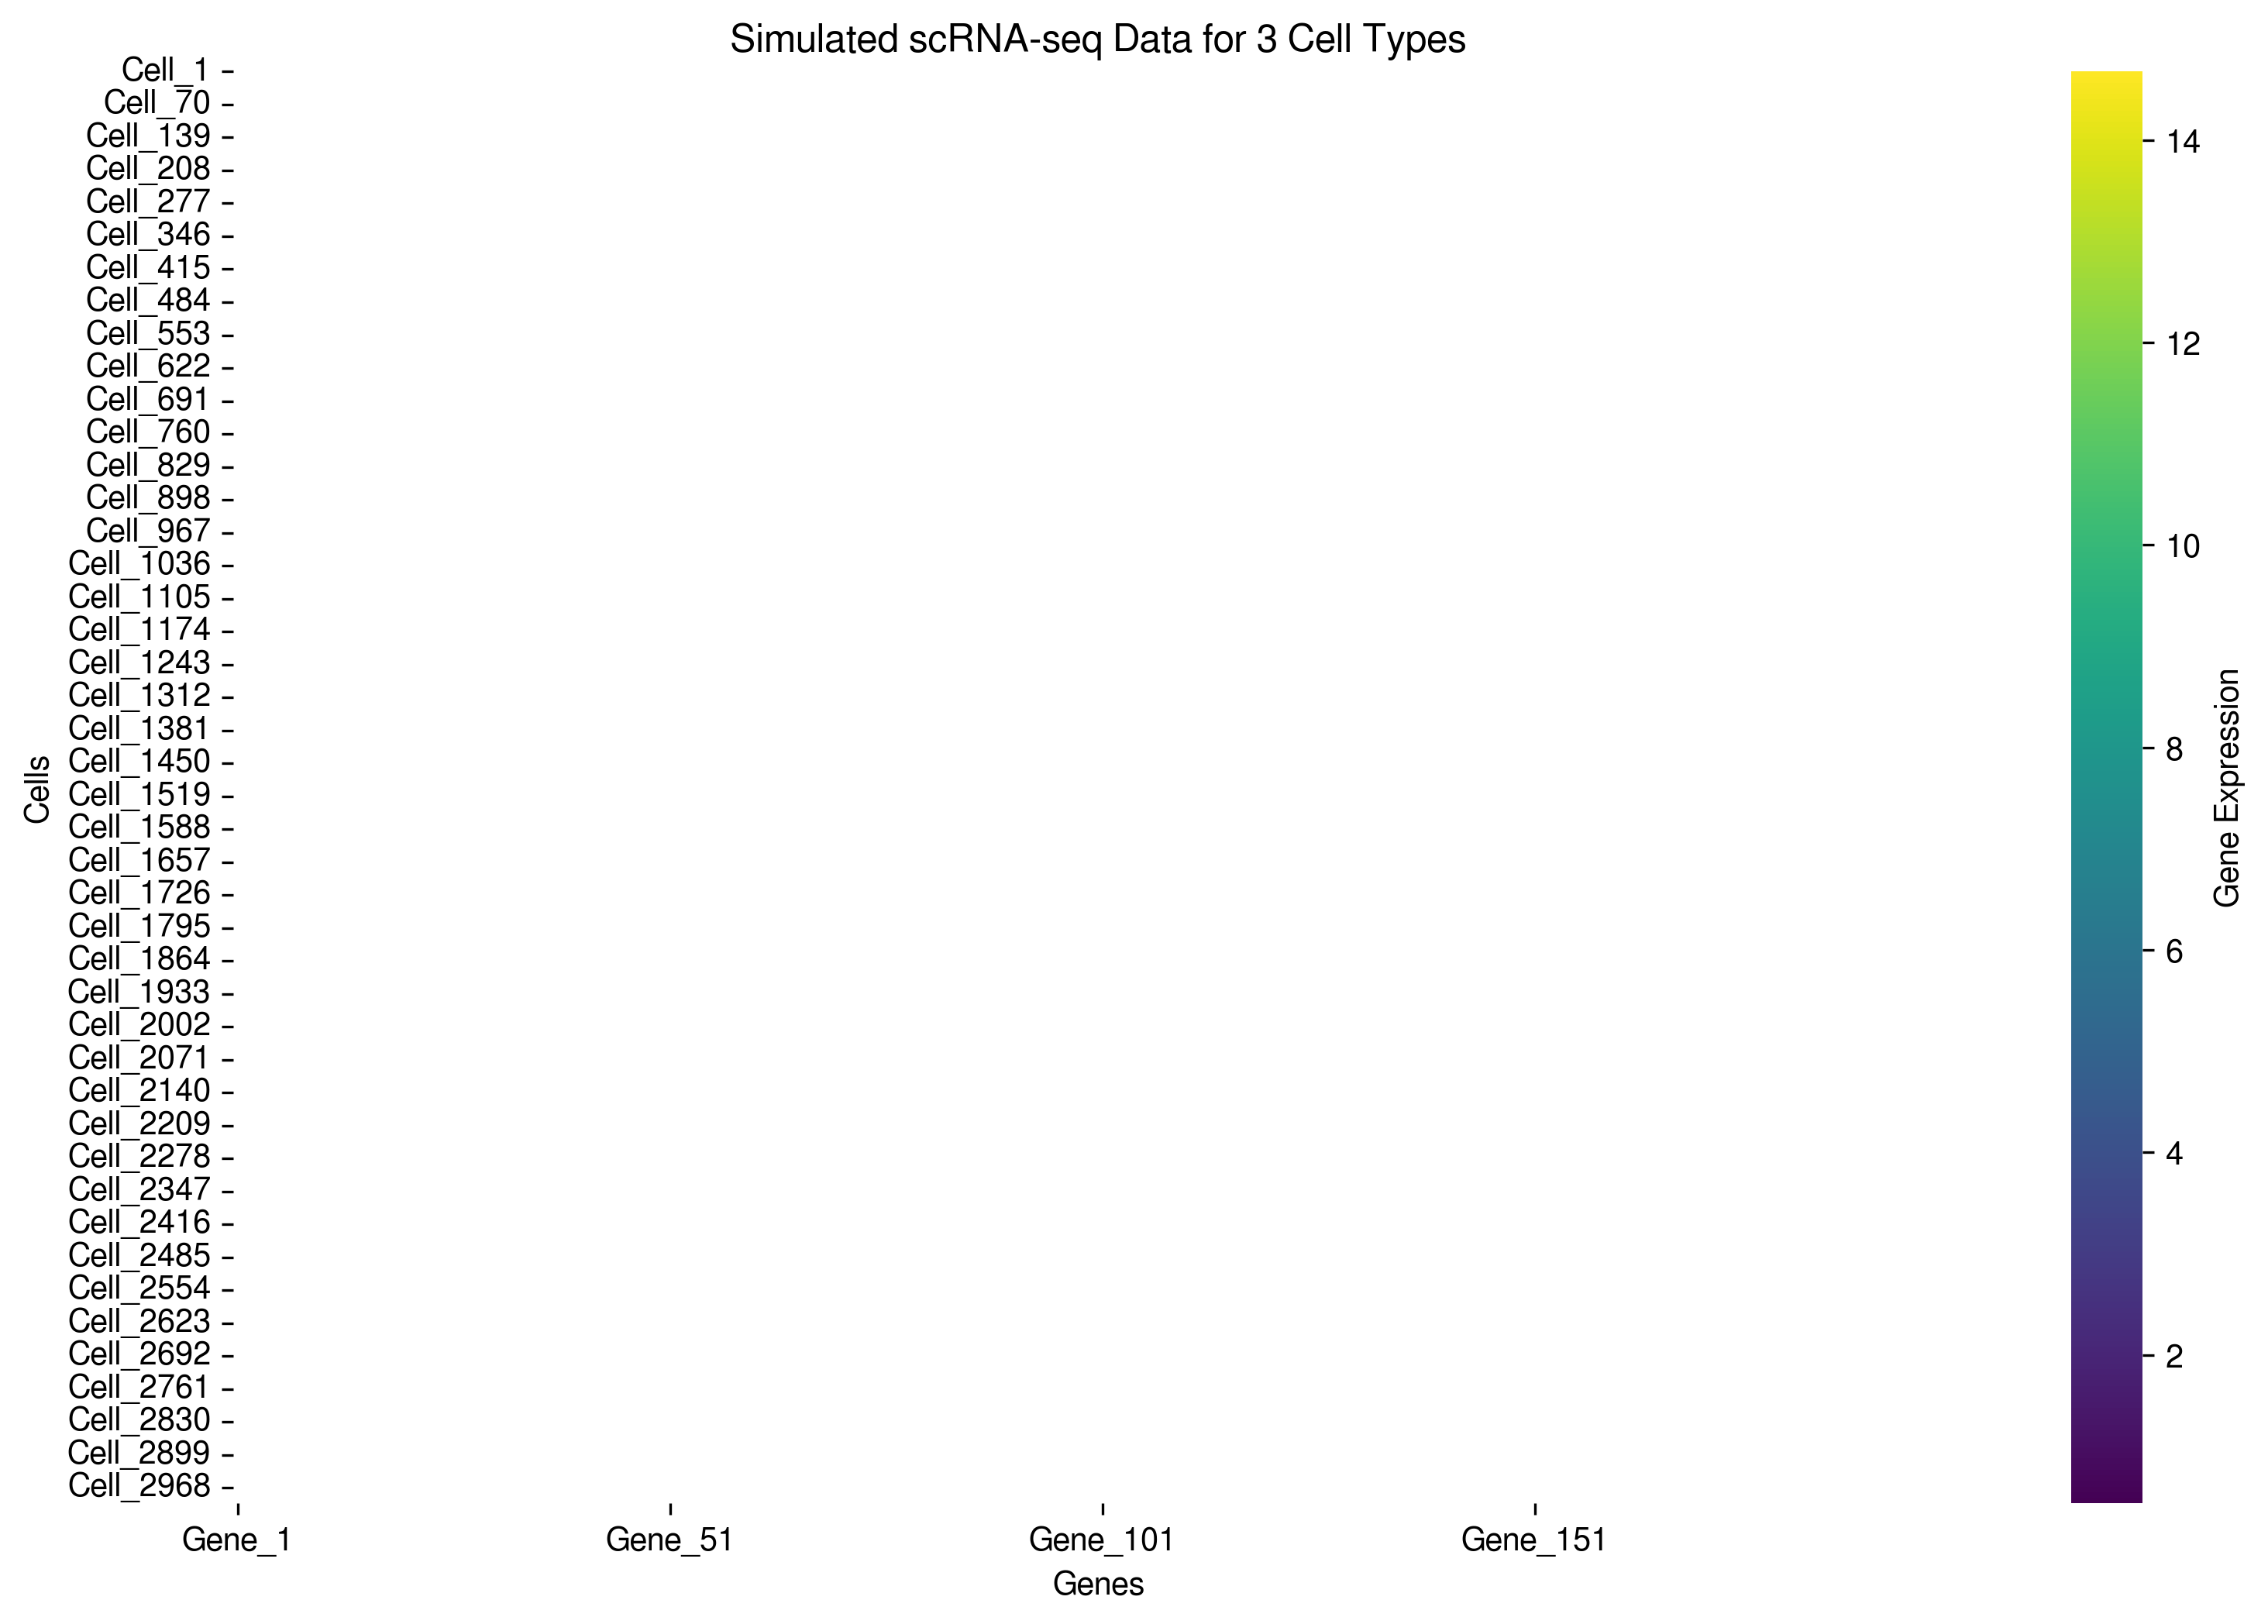

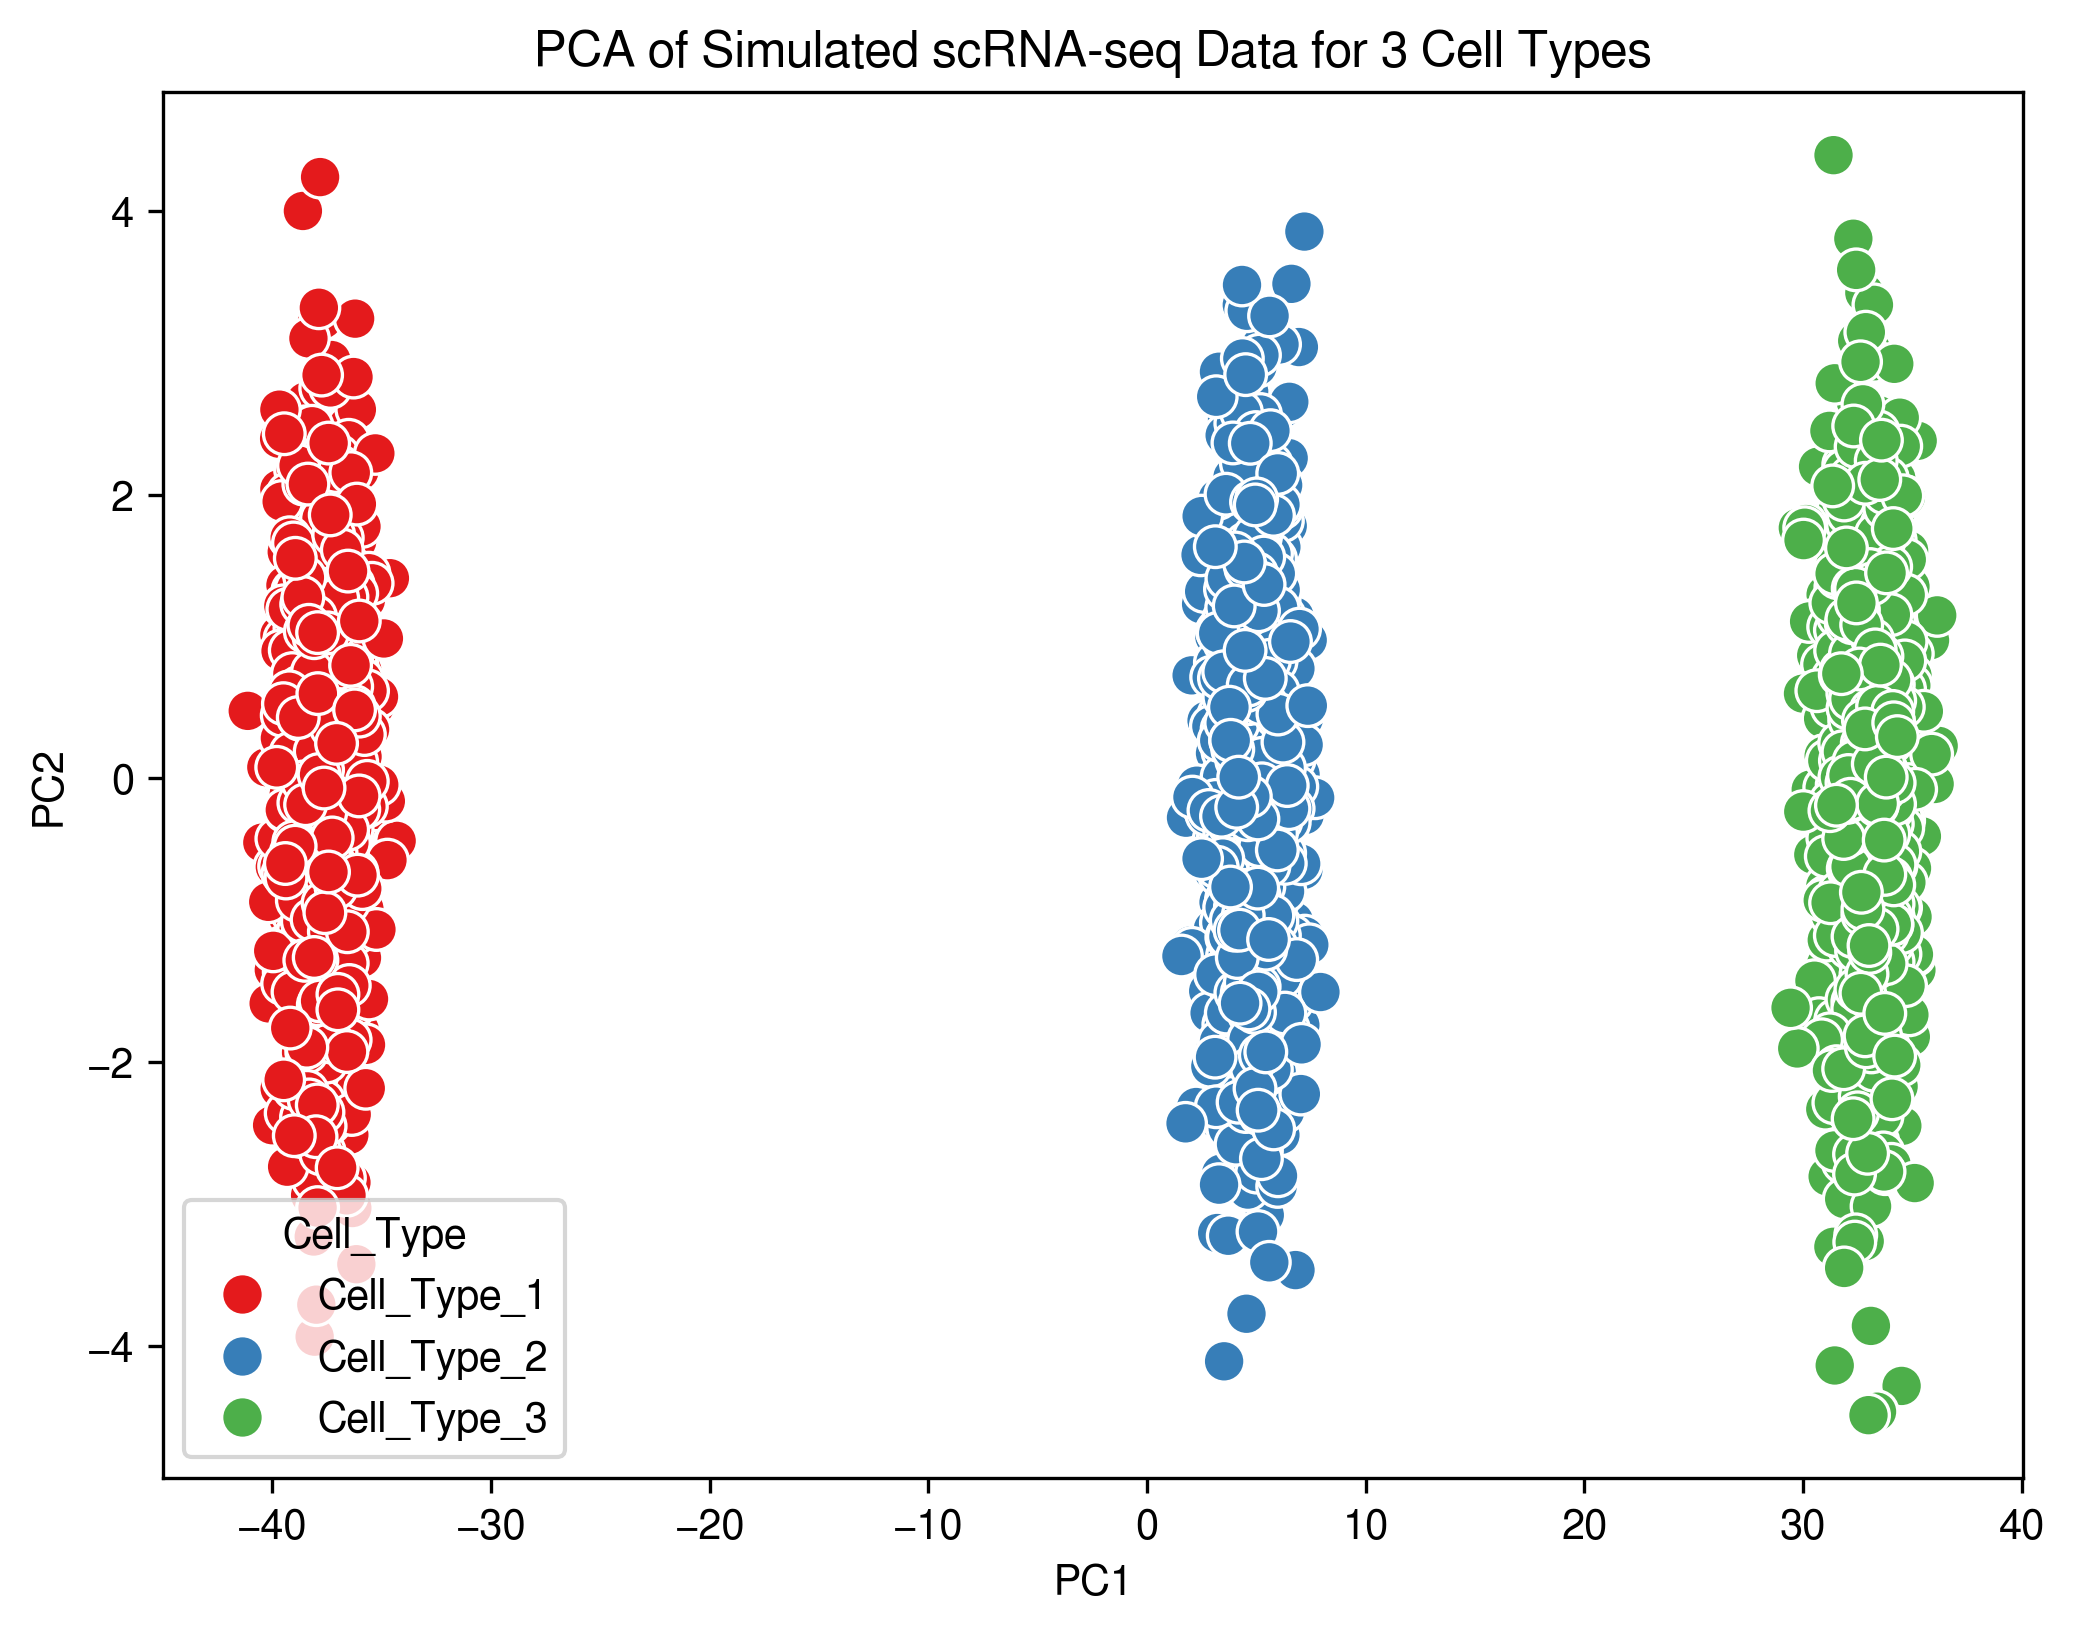

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set parameters
num_cells = 3000  # Total number of cells
num_genes = 200  # Number of genes
num_cell_types = 3  # Three cell types
mean_expression = [5,8,10]  # Mean expression for each cell type
std_dev_expression = [1,1,1]  # Standard deviation for each cell type
cells_per_type = num_cells // num_cell_types  # Number of cells per cell type
noise_factor = 0.5  # 50% noise added to the data

# Simulate the data
np.random.seed(42)  # for reproducibility

# Create an empty DataFrame to hold the simulated data
data = np.zeros((num_cells, num_genes))

# Assign gene expression levels for each cell type
for cell_type in range(num_cell_types):
    start_cell = cell_type * cells_per_type
    end_cell = (cell_type + 1) * cells_per_type
    
    # Generate random gene expression data from a Gaussian distribution
    data[start_cell:end_cell, :] = np.random.normal(
        loc=mean_expression[cell_type],
        scale=std_dev_expression[cell_type],
        size=(cells_per_type, num_genes)
    )

# Add random noise to simulate technical variation
data_with_noise = data# + np.random.normal(0, noise_factor, data.shape)

# Clip negative values to zero
data_with_noise = np.maximum(data_with_noise, 0)


# Create DataFrame
cell_ids = [f'Cell_{i+1}' for i in range(num_cells)]
gene_names = [f'Gene_{i+1}' for i in range(num_genes)]
df = pd.DataFrame(data_with_noise, index=cell_ids, columns=gene_names)

# Assign cell types (labels) for each cell
cell_types = ['Cell_Type_1'] * cells_per_type + ['Cell_Type_2'] * cells_per_type + ['Cell_Type_3'] * cells_per_type
df['Cell_Type'] = cell_types

# Show first few rows
print(df.head())

# Optionally, visualize the data (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, :-1], cmap='viridis', linewidths=0.1, cbar_kws={'label': 'Gene Expression'}, xticklabels=50)
plt.title("Simulated scRNA-seq Data for 3 Cell Types")
plt.xlabel("Genes")
plt.ylabel("Cells")
plt.show()

# Optionally, perform PCA to see how the cell types separate
from sklearn.decomposition import PCA

# Exclude the 'Cell_Type' column for PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df.iloc[:, :-1])

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cell_Type'] = df['Cell_Type'].values

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cell_Type', palette='Set1', s=100)
plt.title('PCA of Simulated scRNA-seq Data for 3 Cell Types')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


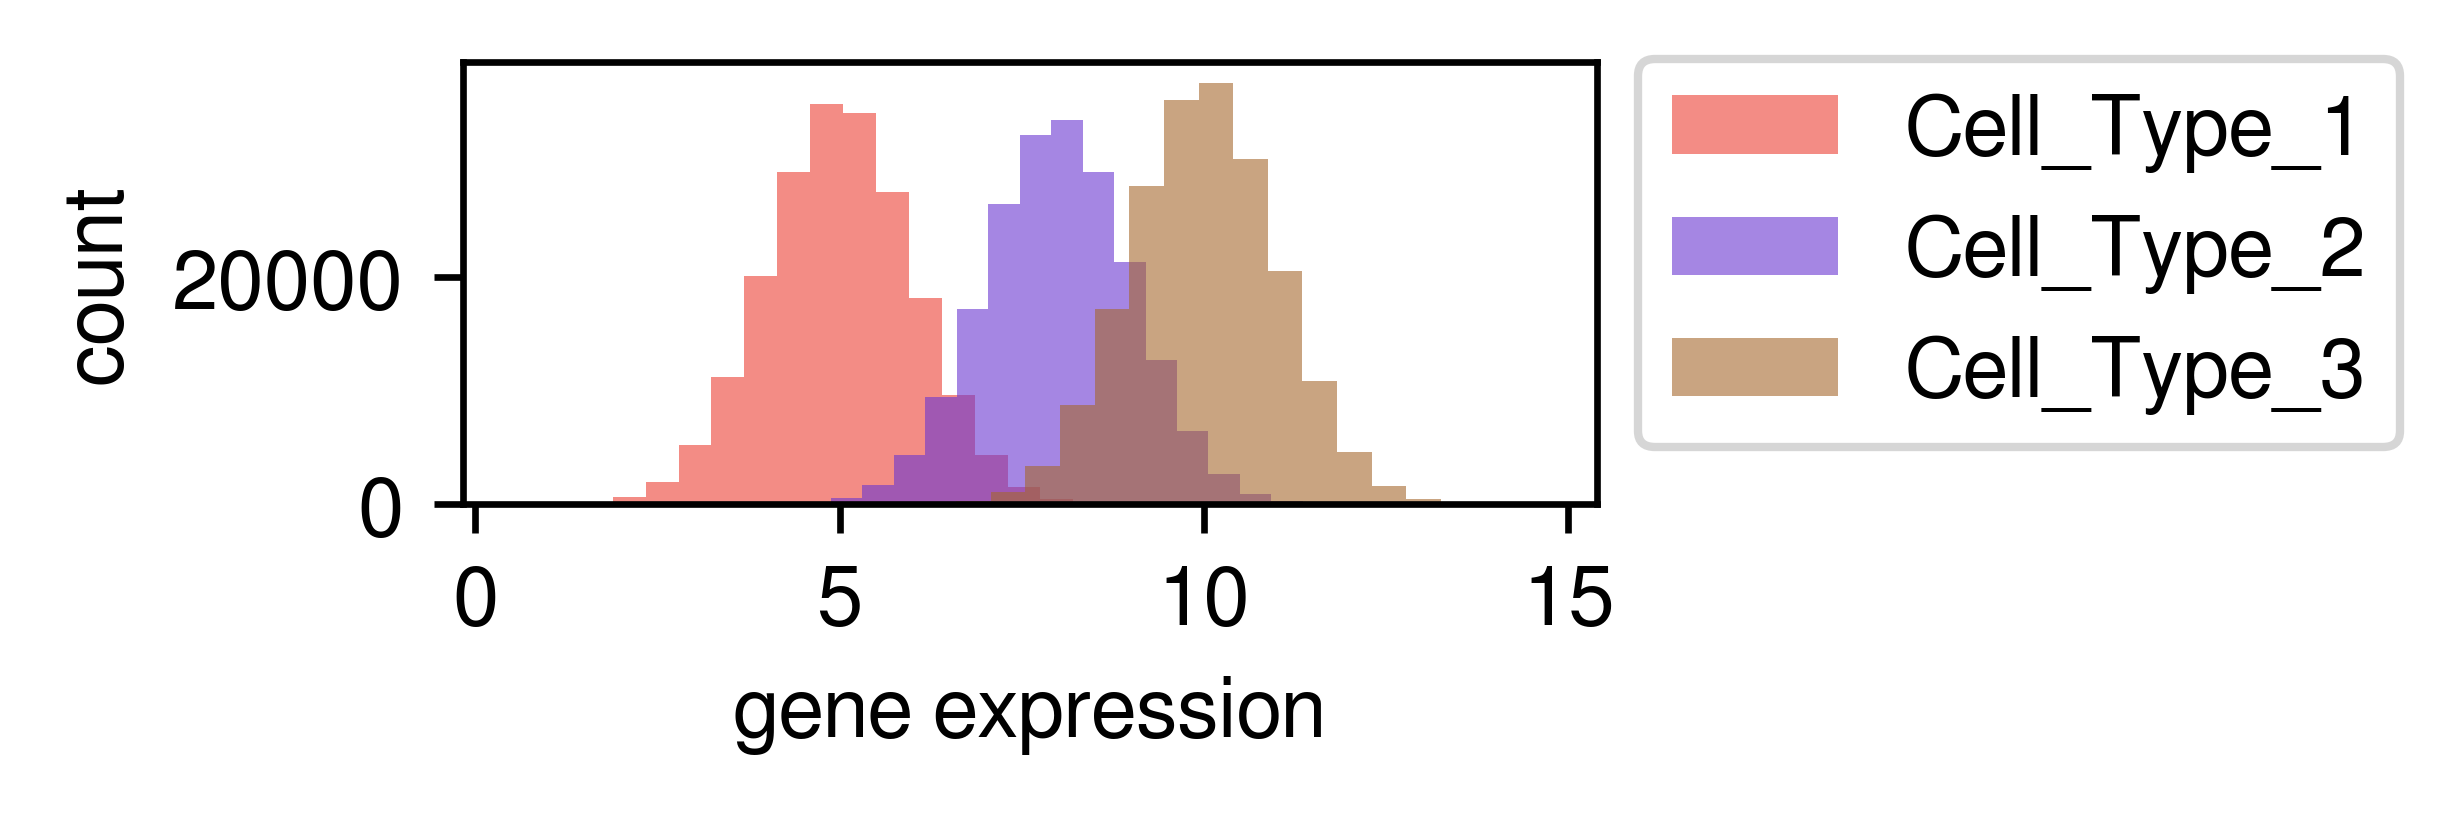

In [169]:
fig,ax = plt.subplots(figsize=(4.2, 1.5), dpi=600)

plt.hist(df.iloc[:,:-1][df.iloc[:,-1] == 'Cell_Type_1'].values.flatten(), 
             alpha=0.6, color = '#eb4034',bins=20)
plt.hist(df.iloc[:,:-1][df.iloc[:,-1] == 'Cell_Type_2'].values.flatten(), 
             alpha=0.6, color = '#6a36d1',bins=20)
plt.hist(df.iloc[:,:-1][df.iloc[:,-1] == 'Cell_Type_3'].values.flatten(), 
             alpha=0.6, color = '#a6672d',bins=20)

plt.legend(['Cell_Type_1','Cell_Type_2','Cell_Type_3'],bbox_to_anchor=(1,1.1))

plt.xlabel('gene expression')
plt.ylabel('count')

fig.tight_layout()
group_name = 'fig1'
fig.savefig(f'figures/{group_name}/{group_name}_simudata_dist.pdf', transparent=True)

(-10.0, 300.0)

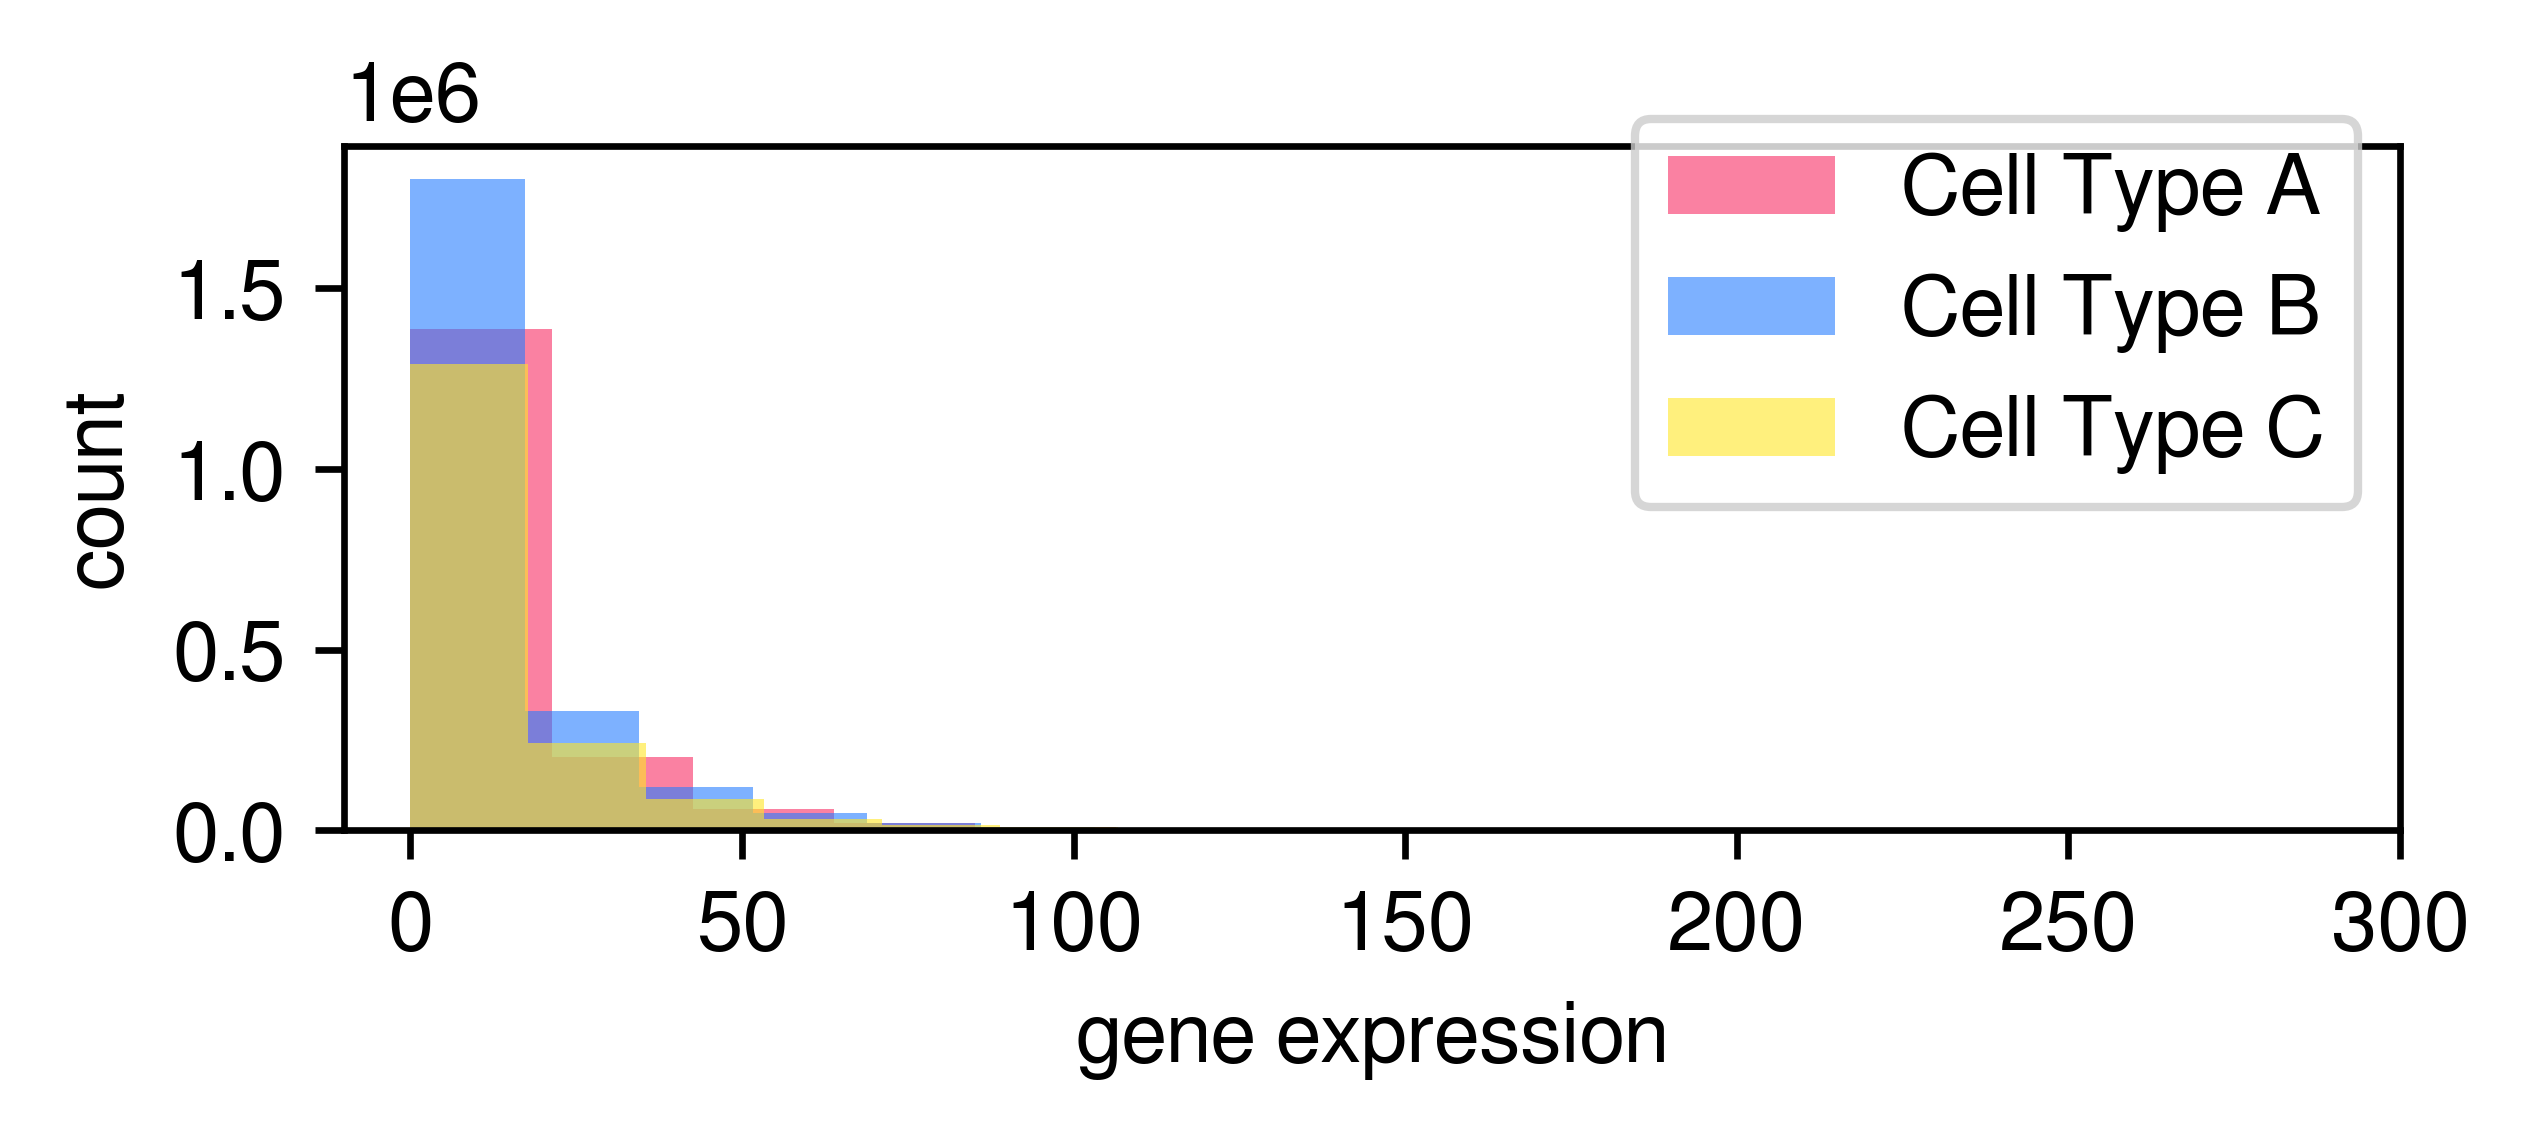

In [170]:
fig,ax = plt.subplots(figsize=(4.2, 2), dpi=600)

plt.hist(adata[adata.obs['Group'] == 'Group1'].X.flatten(), 
             alpha=0.6, color = '#f72d65',bins=200)
plt.hist(adata[adata.obs['Group'] == 'Group2'].X.flatten(), 
             alpha=0.6, color = '#267dff',bins=200)
plt.hist(adata[adata.obs['Group'] == 'Group3'].X.flatten(), 
             alpha=0.6, color = '#ffe626',bins=200)


plt.legend(['Cell Type A','Cell Type B','Cell Type C'],bbox_to_anchor=(1,1.1))

plt.xlabel('gene expression')
plt.ylabel('count')

fig.tight_layout()
group_name = 'fig1'
fig.savefig(f'figures/{group_name}/{group_name}_simudata_dist2.pdf', transparent=True)

plt.xlim([-10,300])

In [171]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the most highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=100)

# Filter the dataset to keep only these genes
adata = adata[:, adata.var.highly_variable]

In [172]:
adata_gaussian = anndata.AnnData(df.iloc[:,:-1])
adata_gaussian.obs['Group'] = df.iloc[:,-1].values

#sc.pp.filter_cells(adata_gaussian, min_genes=200)
#sc.pp.filter_genes(adata_gaussian, min_cells=3)
sc.pp.normalize_total(adata_gaussian, target_sum=1e4)
sc.pp.log1p(adata_gaussian)

# Identify the most highly variable genes
sc.pp.highly_variable_genes(adata_gaussian, n_top_genes=100)

# Filter the dataset to keep only these genes
adata_gaussian = adata_gaussian[:, adata_gaussian.var.highly_variable]

In [173]:
adata_gaussian.to_df().max().max()

4.54111067745851

In [174]:
group = adata.obs['Group'].map(
    {'Group1':1,
     'Group2':2,
     'Group3':3,
    }
)
del adata.obs
del adata.var
del adata.uns
del adata.layers
adata.obs['Group'] = group



In [175]:
group = adata_gaussian.obs['Group'].map(
    {'Cell_Type_1':1,
     'Cell_Type_2':2,
     'Cell_Type_3':3,
    }
)
del adata_gaussian.obs
del adata_gaussian.var
del adata_gaussian.uns
del adata_gaussian.layers
adata_gaussian.obs['Group'] = group

In [176]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scanpy as sc

# Assuming 'adata' is your AnnData object
# First, we need to create an index for the cells
cell_indices = np.arange(adata.n_obs)

# Split indices into 80% for training and 20% for testing
train_indices, test_indices = train_test_split(cell_indices, test_size=0.2, random_state=42)

# Create the training and test subsets
adata_train = adata[train_indices, :].copy()  # Create an AnnData object for training
adata_test = adata[test_indices, :].copy()    # Create an AnnData object for testing

# Now you have two AnnData objects: adata_train and adata_test
# You can check their sizes to confirm the split
print(f"Training data shape: {adata_train.shape}")
print(f"Test data shape: {adata_test.shape}")


Training data shape: (2400, 100)
Test data shape: (600, 100)


In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scanpy as sc

# Assuming 'adata' is your AnnData object
# First, we need to create an index for the cells
cell_indices = np.arange(adata_gaussian.n_obs)

# Split indices into 80% for training and 20% for testing
train_indices, test_indices = train_test_split(cell_indices, test_size=0.2, random_state=42)

# Create the training and test subsets
adata_gaussian_train = adata_gaussian[train_indices, :].copy()  # Create an AnnData object for training
adata_gaussian_test = adata_gaussian[test_indices, :].copy()    # Create an AnnData object for testing

# Now you have two AnnData objects: adata_train and adata_test
# You can check their sizes to confirm the split
print(f"Training data shape: {adata_gaussian_train.shape}")
print(f"Test data shape: {adata_gaussian_test.shape}")


Training data shape: (2400, 100)
Test data shape: (600, 100)


In [178]:
adata_gaussian_train

AnnData object with n_obs × n_vars = 2400 × 100
    obs: 'Group'

In [179]:
adata_train.write('/hpc/mydata/siyu.he/Siyu_projects/Squidiff/datasets/sc_simu_train.h5ad')
adata_test.write('/hpc/mydata/siyu.he/Siyu_projects/Squidiff/datasets/sc_simu_test.h5ad')


In [180]:

adata_gaussian_train.write('/hpc/mydata/siyu.he/Siyu_projects/Squidiff/datasets/sc_gaussian_train.h5ad')
adata_gaussian_test.write('/hpc/mydata/siyu.he/Siyu_projects/Squidiff/datasets/sc_gaussian_test.h5ad')
